# Imports and Settings

In [1]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.regularizers import l1_l2
from keras.optimizers import SGD, Adam
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, roc_curve, auc
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, AveragePooling2D
from names import Names as n
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier
from notebook_functions import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

# Configure Variables

In [5]:
data = pd.read_csv("experiment_data/processed/final_strateos_sample.csv")
color_channel_to_use = "RL1"
use_stain_in_AutoGater = True

In [6]:
data["timepoint"].value_counts()

6.0    270000
3.0    270000
0.5    270000
Name: timepoint, dtype: int64

In [7]:
df = data.loc[data["stain"] == 1]

In [8]:
stain_cols = ["{}-A".format(color_channel_to_use), 
              "{}-H".format(color_channel_to_use),
              "{}-W".format(color_channel_to_use)]
all_features = n.morph_cols + stain_cols

if use_stain_in_AutoGater:
    features = all_features
else:
    features = n.morph_cols
    
print("Features that we will use: {}".format(features))

Features that we will use: ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'RL1-A', 'RL1-H', 'RL1-W']


# Our equivalent of "samples" will be timepoint + concentration 
(maybe add replicates later)

# Model 1: sample-level prediction of >50% CFU percent_live

In [9]:
df1 = df.drop(columns=["BL1-A", "BL1-H", "BL1-W", "source", "stain"]).reset_index(drop=True)
df1["cfu_live"] = (df1["percent_live"] > 50.0).astype(int)
df1

,inducer_concentration,timepoint,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,RL1-A,RL1-H,RL1-W,percent_live,cfu_live
0,0.0,0.5,5.025396,4.909829,1.653213,4.694781,4.554477,1.556303,1.278754,2.130334,0.0,98.776667,1
1,0.0,0.5,4.902123,4.802822,1.612784,4.632214,4.491474,1.531479,0.477121,2.120574,0.0,98.776667,1
2,0.0,0.5,5.250283,4.892784,1.919078,4.977938,4.585133,1.826075,2.292256,2.252853,0.0,98.776667,1
3,0.0,0.5,5.001284,4.810011,1.662758,4.677525,4.501812,1.568202,0.000000,2.037426,0.0,98.776667,1
4,0.0,0.5,4.865702,4.775749,1.602060,4.513697,4.420022,1.477121,0.000000,1.568202,0.0,98.776667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
404995,80.0,6.0,4.256164,3.546172,0.000000,0.000000,2.257679,0.000000,0.000000,1.763428,0.0,0.000000,0
404996,80.0,6.0,3.509337,3.339451,0.000000,0.301030,2.887617,0.000000,0.000000,2.012837,0.0,0.000000,0
404997,80.0,6.0,4.814527,3.656098,0.000000,0.000000,2.747412,0.000000,2.654177,2.158362,0.0,0.000000,0
404998,80.0,6.0,3.364176,3.334051,0.000000,3.061075,3.186674,0.000000,2.133539,2.416641,0.0,0.000000,0


In [10]:
# df1.groupby(["inducer_concentration", "timepoint"]).count()

In [11]:
X1 = np.array(list(df1[["inducer_concentration", 
                        "timepoint"] + features].groupby(["inducer_concentration",
                                                          "timepoint"]).apply(pd.DataFrame.to_numpy)))
X1 = np.expand_dims(X1, axis=3)
# drop the columns corresponding to inducer_concentration and timepoint
X1 = X1[:, :, 2:, :]
print(X1.shape)
# display(X1)

(15, 27000, 9, 1)


In [12]:
y1 = df1.groupby(["inducer_concentration", "timepoint"], as_index=False).first()["cfu_live"].values
display(y1)

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
# split into train and test
np.random.seed(5)
train_idx = list(np.random.choice(len(X1), size=9, replace=False))
test_idx = [x for x in list(range(len(X1))) if x not in train_idx]
print("indices of training samples:", train_idx)
print("indices of testing samples:", test_idx)
X1_train = X1[train_idx]
X1_test = X1[test_idx]
print("shape of train matrix:", X1_train.shape)
print("shape of test matrix:", X1_test.shape)
print()
y1_train = y1[train_idx]
y1_test = y1[test_idx]
print("shape of y1_train:", y1_train.shape)
print("shape of y1_test:", y1_test.shape)

indices of training samples: [5, 1, 7, 2, 10, 14, 11, 4, 8]
indices of testing samples: [0, 3, 6, 9, 12, 13]
shape of train matrix: (9, 27000, 9, 1)
shape of test matrix: (6, 27000, 9, 1)

shape of y1_train: (9,)
shape of y1_test: (6,)


### Define Model

In [14]:
# input
model_input = Input(shape=X1_train[0].shape)

# first convolution layer
model_output = Conv2D(3, kernel_size=(1, X1_train.shape[2]),
                 activation=None)(model_input)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# sceond convolution layer
model_output = Conv2D(3, (1, 1), activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# pooling layer
model_output = AveragePooling2D(pool_size=(X1_train.shape[1], 1))(model_output)
model_output = Flatten()(model_output)

# Dense layer
model_output = Dense(3, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# output layer
model_output = Dense(1, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("sigmoid")(model_output)

### Train Model

In [15]:
# specify input and output
model = Model(inputs=[model_input],
              outputs=model_output)

# define loss function and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

# save the best performing model
checkpointer = ModelCheckpoint(filepath='Result/saved_weights.hdf5', 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

# model training
model.fit([X1_train], y1_train,
          batch_size=60,
          epochs=500, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([X1_train], y1_train))

Epoch 1/500
1/1 [==============================] - 0s 311ms/step - loss: 0.6719 - accuracy: 0.5556 - val_loss: 0.6829 - val_accuracy: 0.5556
Epoch 2/500
1/1 [==============================] - 0s 51ms/step - loss: 0.6696 - accuracy: 0.5556 - val_loss: 0.6828 - val_accuracy: 0.5556
Epoch 3/500
1/1 [==============================] - 0s 55ms/step - loss: 0.6672 - accuracy: 0.5556 - val_loss: 0.6827 - val_accuracy: 0.5556
Epoch 4/500
1/1 [==============================] - 0s 66ms/step - loss: 0.6648 - accuracy: 0.5556 - val_loss: 0.6827 - val_accuracy: 0.5556
Epoch 5/500
1/1 [==============================] - 0s 66ms/step - loss: 0.6622 - accuracy: 0.5556 - val_loss: 0.6826 - val_accuracy: 0.5556
Epoch 6/500
1/1 [==============================] - 0s 56ms/step - loss: 0.6598 - accuracy: 0.5556 - val_loss: 0.6826 - val_accuracy: 0.5556
Epoch 7/500
1/1 [==============================] - 0s 53ms/step - loss: 0.6579 - accuracy: 0.5556 - val_loss: 0.6825 - val_accuracy: 0.5556
Epoch 8/500
1/1 [==

1/1 [==============================] - 0s 49ms/step - loss: 0.4890 - accuracy: 0.8889 - val_loss: 0.6996 - val_accuracy: 0.5556
Epoch 60/500
1/1 [==============================] - 0s 50ms/step - loss: 0.4874 - accuracy: 0.8889 - val_loss: 0.6995 - val_accuracy: 0.5556
Epoch 61/500
1/1 [==============================] - 0s 58ms/step - loss: 0.4858 - accuracy: 0.8889 - val_loss: 0.6993 - val_accuracy: 0.5556
Epoch 62/500
1/1 [==============================] - 0s 69ms/step - loss: 0.4842 - accuracy: 0.8889 - val_loss: 0.6991 - val_accuracy: 0.5556
Epoch 63/500
1/1 [==============================] - 0s 48ms/step - loss: 0.4829 - accuracy: 0.8889 - val_loss: 0.6989 - val_accuracy: 0.5556
Epoch 64/500
1/1 [==============================] - 0s 48ms/step - loss: 0.4814 - accuracy: 0.8889 - val_loss: 0.6988 - val_accuracy: 0.5556
Epoch 65/500
1/1 [==============================] - 0s 51ms/step - loss: 0.4801 - accuracy: 0.8889 - val_loss: 0.6986 - val_accuracy: 0.5556
Epoch 66/500
1/1 [========

1/1 [==============================] - 0s 59ms/step - loss: 0.4310 - accuracy: 0.8889 - val_loss: 0.6905 - val_accuracy: 0.5556
Epoch 118/500
1/1 [==============================] - 0s 58ms/step - loss: 0.4300 - accuracy: 0.8889 - val_loss: 0.6906 - val_accuracy: 0.5556
Epoch 119/500
1/1 [==============================] - 0s 74ms/step - loss: 0.4290 - accuracy: 0.8889 - val_loss: 0.6907 - val_accuracy: 0.5556
Epoch 120/500
1/1 [==============================] - 0s 54ms/step - loss: 0.4280 - accuracy: 0.8889 - val_loss: 0.6907 - val_accuracy: 0.5556
Epoch 121/500
1/1 [==============================] - 0s 57ms/step - loss: 0.4272 - accuracy: 0.8889 - val_loss: 0.6908 - val_accuracy: 0.5556
Epoch 122/500
1/1 [==============================] - 0s 52ms/step - loss: 0.4263 - accuracy: 0.8889 - val_loss: 0.6910 - val_accuracy: 0.5556
Epoch 123/500
1/1 [==============================] - 0s 45ms/step - loss: 0.4248 - accuracy: 0.8889 - val_loss: 0.6911 - val_accuracy: 0.5556
Epoch 124/500
1/1 [=

Epoch 175/500
1/1 [==============================] - 0s 54ms/step - loss: 0.3366 - accuracy: 1.0000 - val_loss: 0.7199 - val_accuracy: 0.5556
Epoch 176/500
1/1 [==============================] - 0s 74ms/step - loss: 0.3363 - accuracy: 1.0000 - val_loss: 0.7205 - val_accuracy: 0.5556
Epoch 177/500
1/1 [==============================] - 0s 64ms/step - loss: 0.3357 - accuracy: 1.0000 - val_loss: 0.7210 - val_accuracy: 0.5556
Epoch 178/500
1/1 [==============================] - 0s 48ms/step - loss: 0.3353 - accuracy: 1.0000 - val_loss: 0.7216 - val_accuracy: 0.5556
Epoch 179/500
1/1 [==============================] - 0s 58ms/step - loss: 0.3350 - accuracy: 1.0000 - val_loss: 0.7222 - val_accuracy: 0.5556
Epoch 180/500
1/1 [==============================] - 0s 60ms/step - loss: 0.3348 - accuracy: 1.0000 - val_loss: 0.7228 - val_accuracy: 0.5556
Epoch 181/500
1/1 [==============================] - 0s 46ms/step - loss: 0.3345 - accuracy: 1.0000 - val_loss: 0.7233 - val_accuracy: 0.5556
Epoch 

Epoch 233/500
1/1 [==============================] - 0s 74ms/step - loss: 0.3235 - accuracy: 1.0000 - val_loss: 0.7464 - val_accuracy: 0.5556
Epoch 234/500
1/1 [==============================] - 0s 51ms/step - loss: 0.3235 - accuracy: 1.0000 - val_loss: 0.7465 - val_accuracy: 0.5556
Epoch 235/500
1/1 [==============================] - 0s 51ms/step - loss: 0.3233 - accuracy: 1.0000 - val_loss: 0.7466 - val_accuracy: 0.5556
Epoch 236/500
1/1 [==============================] - 0s 50ms/step - loss: 0.3231 - accuracy: 1.0000 - val_loss: 0.7467 - val_accuracy: 0.5556
Epoch 237/500
1/1 [==============================] - 0s 50ms/step - loss: 0.3230 - accuracy: 1.0000 - val_loss: 0.7467 - val_accuracy: 0.5556
Epoch 238/500
1/1 [==============================] - 0s 48ms/step - loss: 0.3228 - accuracy: 1.0000 - val_loss: 0.7468 - val_accuracy: 0.5556
Epoch 239/500
1/1 [==============================] - 0s 53ms/step - loss: 0.3227 - accuracy: 1.0000 - val_loss: 0.7468 - val_accuracy: 0.5556
Epoch 

Epoch 291/500
1/1 [==============================] - 0s 62ms/step - loss: 0.3173 - accuracy: 1.0000 - val_loss: 0.6576 - val_accuracy: 0.6667
Epoch 292/500
1/1 [==============================] - 0s 51ms/step - loss: 0.3172 - accuracy: 1.0000 - val_loss: 0.6557 - val_accuracy: 0.6667
Epoch 293/500
1/1 [==============================] - 0s 54ms/step - loss: 0.3171 - accuracy: 1.0000 - val_loss: 0.6539 - val_accuracy: 0.6667
Epoch 294/500
1/1 [==============================] - 0s 51ms/step - loss: 0.3170 - accuracy: 1.0000 - val_loss: 0.6520 - val_accuracy: 0.6667
Epoch 295/500
1/1 [==============================] - 0s 50ms/step - loss: 0.3170 - accuracy: 1.0000 - val_loss: 0.6502 - val_accuracy: 0.6667
Epoch 296/500
1/1 [==============================] - 0s 47ms/step - loss: 0.3169 - accuracy: 1.0000 - val_loss: 0.6483 - val_accuracy: 0.6667
Epoch 297/500
1/1 [==============================] - 0s 50ms/step - loss: 0.3168 - accuracy: 1.0000 - val_loss: 0.6465 - val_accuracy: 0.6667
Epoch 

Epoch 349/500
1/1 [==============================] - 0s 51ms/step - loss: 0.3133 - accuracy: 1.0000 - val_loss: 0.5727 - val_accuracy: 0.6667
Epoch 350/500
1/1 [==============================] - 0s 57ms/step - loss: 0.3132 - accuracy: 1.0000 - val_loss: 0.5713 - val_accuracy: 0.6667
Epoch 351/500
1/1 [==============================] - 0s 47ms/step - loss: 0.3132 - accuracy: 1.0000 - val_loss: 0.5700 - val_accuracy: 0.6667
Epoch 352/500
1/1 [==============================] - 0s 47ms/step - loss: 0.3131 - accuracy: 1.0000 - val_loss: 0.5686 - val_accuracy: 0.6667
Epoch 353/500
1/1 [==============================] - 0s 59ms/step - loss: 0.3131 - accuracy: 1.0000 - val_loss: 0.5673 - val_accuracy: 0.6667
Epoch 354/500
1/1 [==============================] - 0s 55ms/step - loss: 0.3130 - accuracy: 1.0000 - val_loss: 0.5659 - val_accuracy: 0.6667
Epoch 355/500
1/1 [==============================] - 0s 51ms/step - loss: 0.3129 - accuracy: 1.0000 - val_loss: 0.5646 - val_accuracy: 0.6667
Epoch 

Epoch 407/500
1/1 [==============================] - 0s 60ms/step - loss: 0.3101 - accuracy: 1.0000 - val_loss: 0.4176 - val_accuracy: 0.8889
Epoch 408/500
1/1 [==============================] - 0s 56ms/step - loss: 0.3100 - accuracy: 1.0000 - val_loss: 0.4144 - val_accuracy: 0.8889
Epoch 409/500
1/1 [==============================] - 0s 46ms/step - loss: 0.3100 - accuracy: 1.0000 - val_loss: 0.4112 - val_accuracy: 1.0000
Epoch 410/500
1/1 [==============================] - 0s 51ms/step - loss: 0.3099 - accuracy: 1.0000 - val_loss: 0.4081 - val_accuracy: 1.0000
Epoch 411/500
1/1 [==============================] - 0s 62ms/step - loss: 0.3099 - accuracy: 1.0000 - val_loss: 0.4051 - val_accuracy: 1.0000
Epoch 412/500
1/1 [==============================] - 0s 48ms/step - loss: 0.3098 - accuracy: 1.0000 - val_loss: 0.4021 - val_accuracy: 1.0000
Epoch 413/500
1/1 [==============================] - 0s 50ms/step - loss: 0.3098 - accuracy: 1.0000 - val_loss: 0.3991 - val_accuracy: 1.0000
Epoch 

Epoch 465/500
1/1 [==============================] - 0s 45ms/step - loss: 0.3072 - accuracy: 1.0000 - val_loss: 0.3502 - val_accuracy: 1.0000
Epoch 466/500
1/1 [==============================] - 0s 47ms/step - loss: 0.3071 - accuracy: 1.0000 - val_loss: 0.3508 - val_accuracy: 1.0000
Epoch 467/500
1/1 [==============================] - 0s 59ms/step - loss: 0.3071 - accuracy: 1.0000 - val_loss: 0.3514 - val_accuracy: 1.0000
Epoch 468/500
1/1 [==============================] - 0s 55ms/step - loss: 0.3071 - accuracy: 1.0000 - val_loss: 0.3521 - val_accuracy: 1.0000
Epoch 469/500
1/1 [==============================] - 0s 62ms/step - loss: 0.3070 - accuracy: 1.0000 - val_loss: 0.3527 - val_accuracy: 1.0000
Epoch 470/500
1/1 [==============================] - 0s 53ms/step - loss: 0.3069 - accuracy: 1.0000 - val_loss: 0.3533 - val_accuracy: 1.0000
Epoch 471/500
1/1 [==============================] - 0s 64ms/step - loss: 0.3069 - accuracy: 1.0000 - val_loss: 0.3540 - val_accuracy: 1.0000
Epoch 

### Plot losses

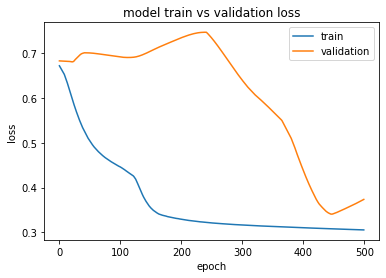

In [16]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Evaluate on test data

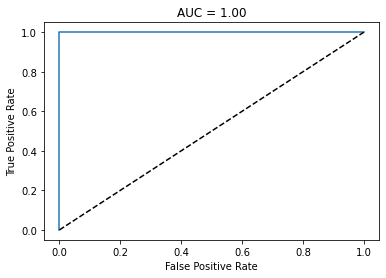

In [17]:
# # load final model
# final_model = load_model('Data/Final_weights.hdf5')

# generate ROC and AUC
y_scores = model.predict([X1_test])
fpr, tpr, _ = roc_curve(y1_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = {0:.2f}'.format(roc_auc))
plt.show()

Next steps:
1. Increase number of samples from 15 --> 60, and potentially split by replicates (if exist) to make even more samples
2. Figure out how to see which cells in each sample activate which CNN filters.
3. Predict other values (see below)

# Model 2: sample-level prediction of live/dead based on stain value majority

# Model 3: sample-level prediction of concentration

# Model 4: sample-level prediction of CFU percent_live